# Semantic Segmentation

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

Download the pet dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2TEMUW/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2TEMUW/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


# **U_NET:**


# Preprocessing data


In [3]:
NUM_EPOCHS = 30
image_size = 128

In [4]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (image_size, image_size), method="nearest")
   input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")
   return input_image, input_mask

In [5]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # suitable Augmentation transforms
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train_with_augment(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [7]:
def load_image_train_without_augment(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [8]:
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

**With Data Augmentation**

In [ ]:
train_dataset = dataset["train"].map(load_image_train_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

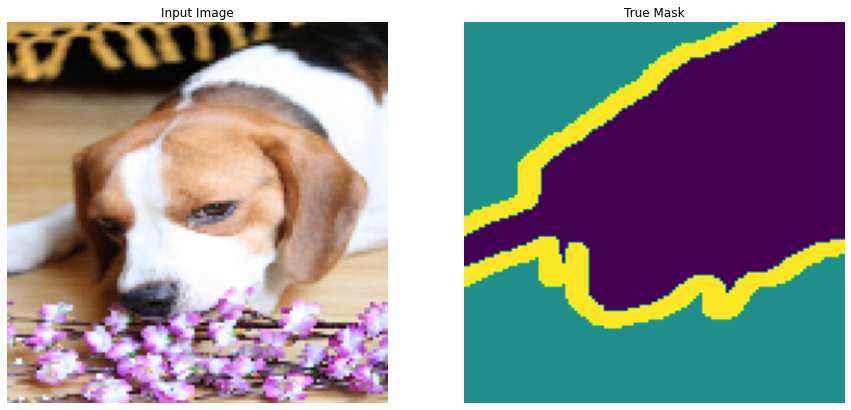

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# UNet Architecture
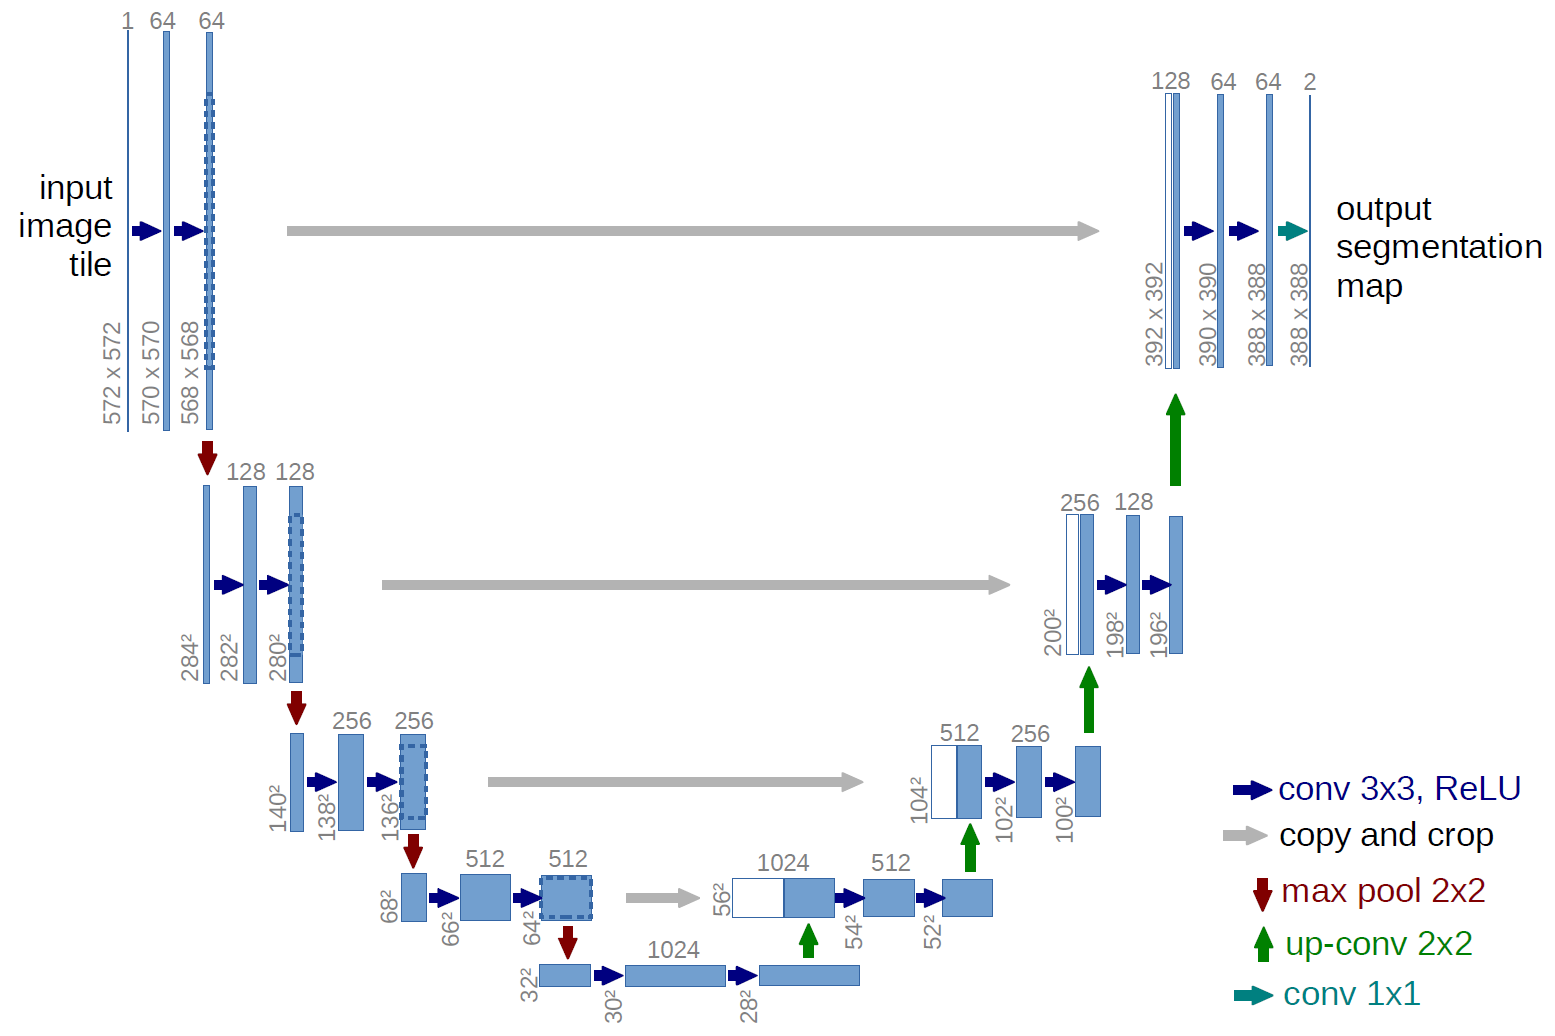



You can use the following link to get acquainted with convolution2d_transpose:


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

In this part:

1.   Design UNet Encoder-Decoder model layer by layer with Keras tool
2.   Compile your model
3.   Train model, show and plot accuracy and loss
4.   display some of predicted masks beside related true masks

Notes:

Use Adam optimizer with learning rate 0.001 and sparse_categorical_crossentropy as loss function

Set accuracy for metrics


In [9]:
# get help from: https://github.com/margaretmz/image-segmentation/blob/main/unet_pet_segmentation.ipynb
def twod_conv(x, n_filters):

   # Conv2D layers and activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample(x, n_filters):
   f = twod_conv(x, n_filters)
   # pooling and droupout
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # conv layers
   x = twod_conv(x, n_filters)

   return x

def unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # downsample
   f1, p1 = downsample(inputs, 64)
   f2, p2 = downsample(p1, 128)
   f3, p3 = downsample(p2, 256)
   f4, p4 = downsample(p3, 512)

   # bottleneck
   bottleneck = twod_conv(p4, 1024)

   # decoder: expanding path - upsample
   # upsample
   u6 = upsample(bottleneck, f4, 512)
   u7 = upsample(u6, f3, 256)
   u8 = upsample(u7, f2, 128)
   u9 = upsample(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [12]:
# summary
unet_model = unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

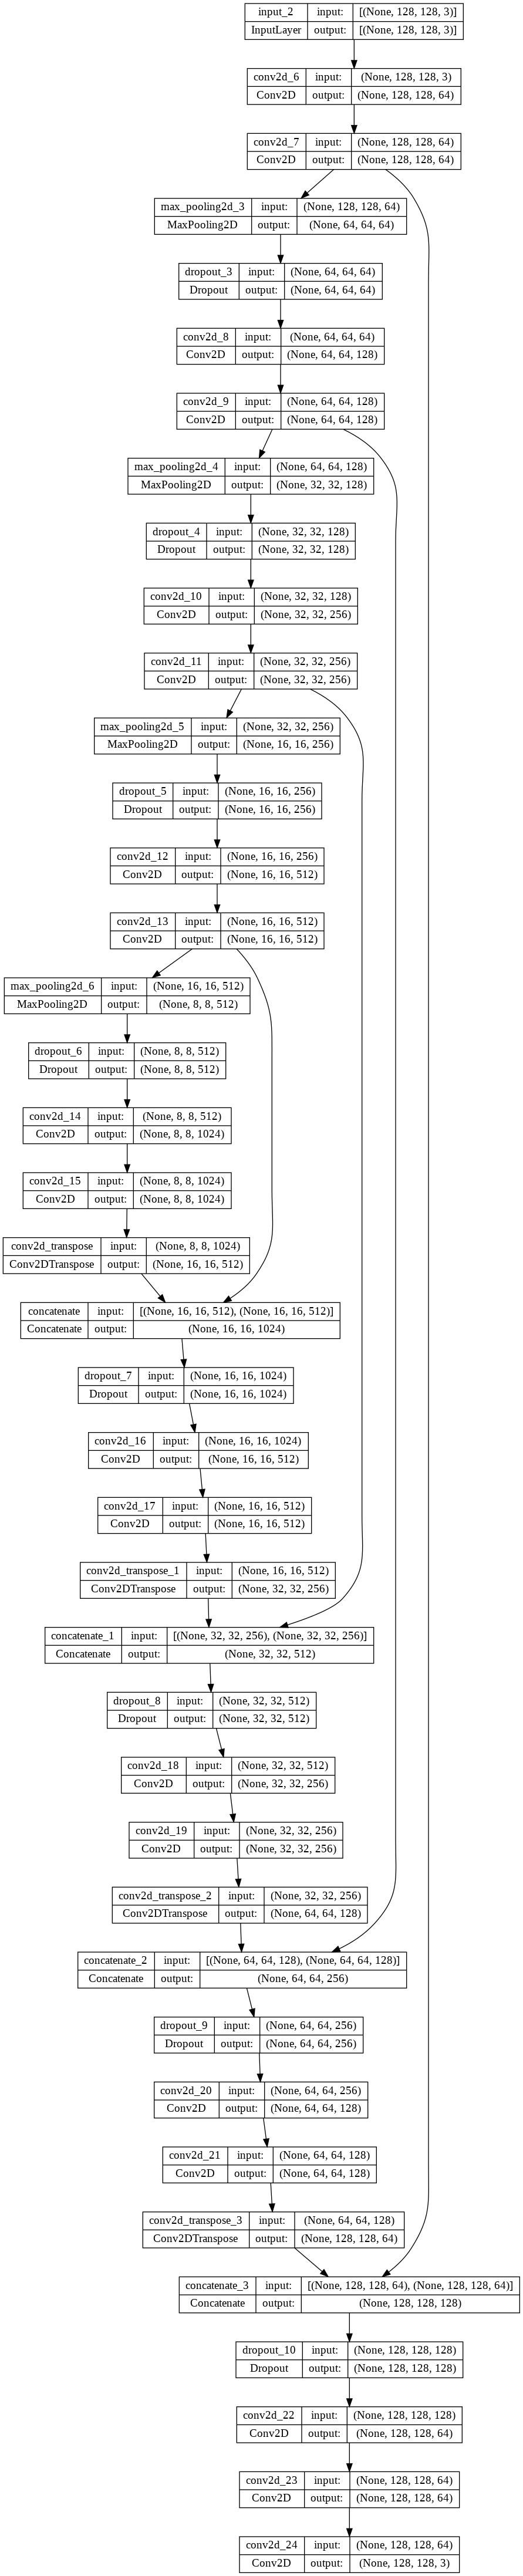

In [ ]:
# plot
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
# compile
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
# train
NUM_EPOCHS = 30

TRAIN_LEN = info.splits["train"].num_examples
STEPS = TRAIN_LEN // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LEN = info.splits["test"].num_examples
VAL_STEPS = TEST_LEN // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS,
                              validation_steps=VAL_STEPS,
                              validation_data=test_batches)

Epoch 1/30
57/57 [==============================] - 93s 1s/step - loss: 0.9128 - accuracy: 0.5855 - val_loss: 0.7933 - val_accuracy: 0.6252
Epoch 2/30
57/57 [==============================] - 71s 1s/step - loss: 0.8048 - accuracy: 0.6437 - val_loss: 0.7251 - val_accuracy: 0.7057
Epoch 3/30
57/57 [==============================] - 64s 1s/step - loss: 0.6876 - accuracy: 0.7217 - val_loss: 0.6583 - val_accuracy: 0.7331
Epoch 4/30
57/57 [==============================] - 63s 1s/step - loss: 0.6323 - accuracy: 0.7436 - val_loss: 0.6185 - val_accuracy: 0.7524
Epoch 5/30
57/57 [==============================] - 63s 1s/step - loss: 0.5662 - accuracy: 0.7752 - val_loss: 0.5003 - val_accuracy: 0.8021
Epoch 6/30
57/57 [==============================] - 63s 1s/step - loss: 0.5116 - accuracy: 0.7995 - val_loss: 0.4730 - val_accuracy: 0.8118
Epoch 7/30
57/57 [==============================] - 63s 1s/step - loss: 0.4692 - accuracy: 0.8183 - val_loss: 0.4342 - val_accuracy: 0.8323
Epoch 8/30
57/57 [==

In [10]:
def learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

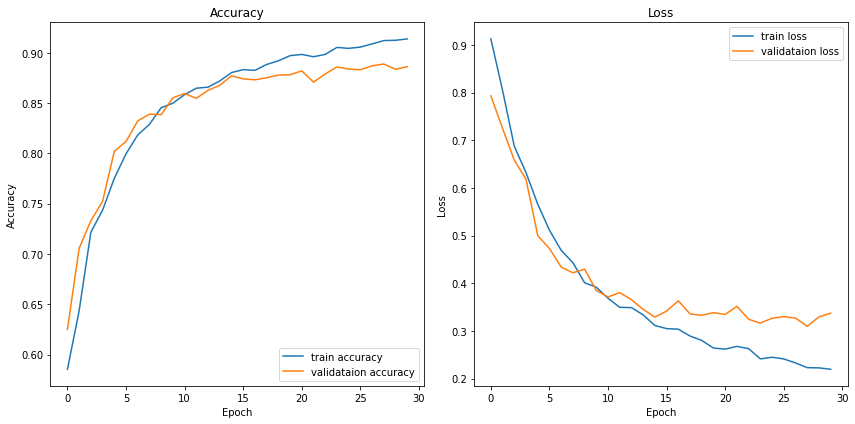

In [ ]:
# Display learning curves 
learning_curves(unet_model.history)

number of batches: 11
2/2 [==============================] - 0s 202ms/step


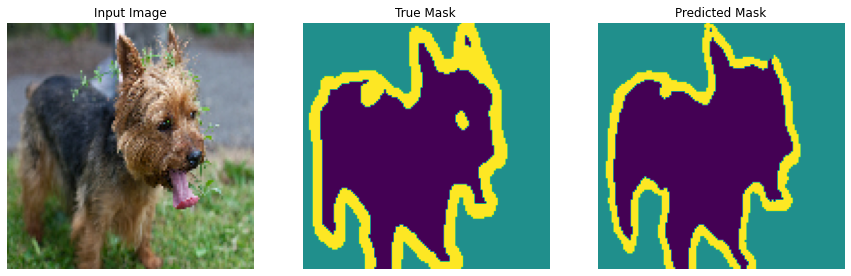

2/2 [==============================] - 0s 143ms/step


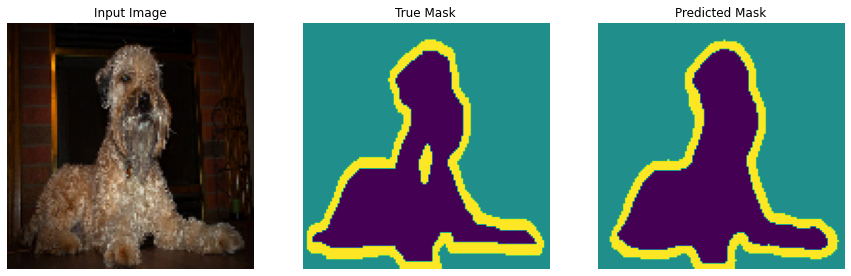

2/2 [==============================] - 0s 144ms/step


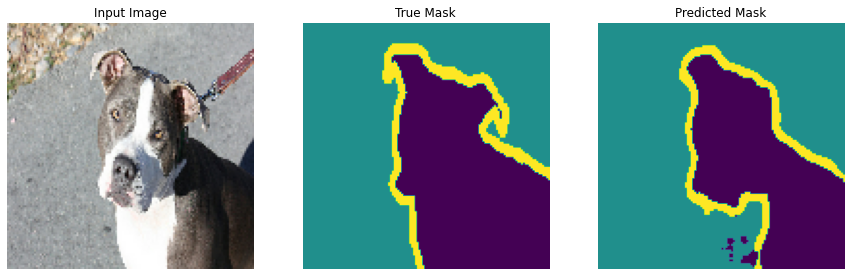

In [ ]:
# prediction
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

# show
predictions(test_batches.skip(5), 3)

**Without Data Augmentation**

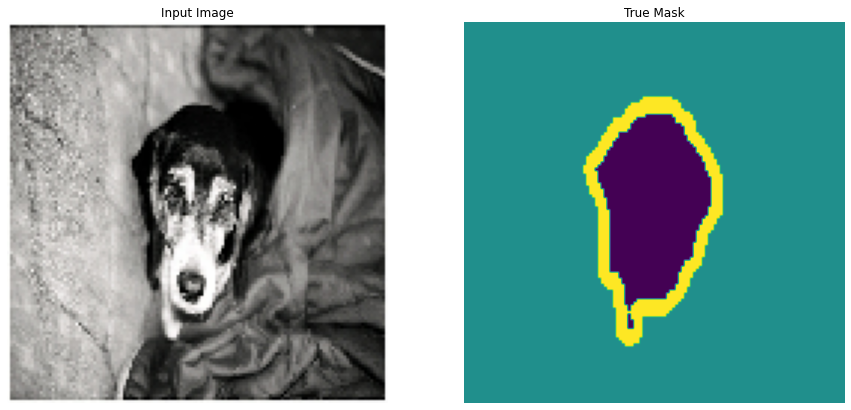

In [11]:
train_dataset = dataset["train"].map(load_image_train_without_augment, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [13]:
# compile
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
# train
NUM_EPOCHS = 30

TRAIN_LEN = info.splits["train"].num_examples
STEPS = TRAIN_LEN // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LEN = info.splits["test"].num_examples
VAL_STEPS = TEST_LEN // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS,
                              validation_steps=VAL_STEPS,
                              validation_data=test_batches)

Epoch 1/30
57/57 [==============================] - 91s 1s/step - loss: 0.9600 - accuracy: 0.5664 - val_loss: 0.8370 - val_accuracy: 0.5865
Epoch 2/30
57/57 [==============================] - 72s 1s/step - loss: 0.7965 - accuracy: 0.6305 - val_loss: 0.7226 - val_accuracy: 0.6979
Epoch 3/30
57/57 [==============================] - 64s 1s/step - loss: 0.6667 - accuracy: 0.7290 - val_loss: 0.6016 - val_accuracy: 0.7599
Epoch 4/30
57/57 [==============================] - 64s 1s/step - loss: 0.5978 - accuracy: 0.7626 - val_loss: 0.5622 - val_accuracy: 0.7755
Epoch 5/30
57/57 [==============================] - 64s 1s/step - loss: 0.5655 - accuracy: 0.7771 - val_loss: 0.5734 - val_accuracy: 0.7673
Epoch 6/30
57/57 [==============================] - 64s 1s/step - loss: 0.5190 - accuracy: 0.7951 - val_loss: 0.4896 - val_accuracy: 0.8122
Epoch 7/30
57/57 [==============================] - 64s 1s/step - loss: 0.4900 - accuracy: 0.8093 - val_loss: 0.4490 - val_accuracy: 0.8248
Epoch 8/30
57/57 [==

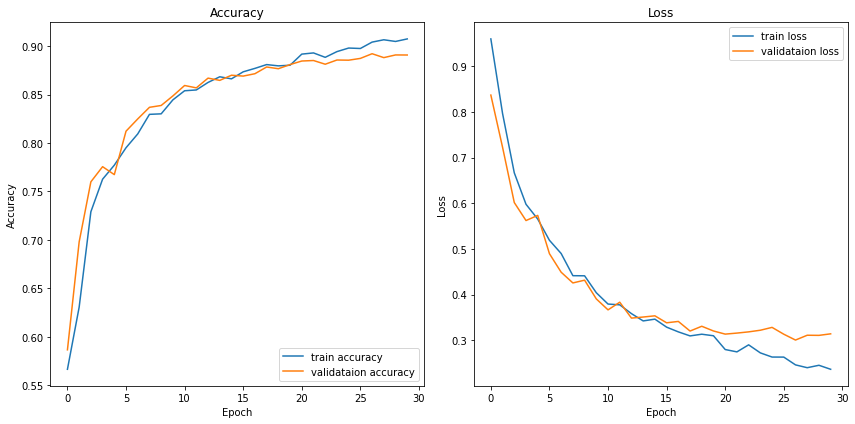

In [14]:
# Display learning curves 
learning_curves(unet_model.history)

**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
# get help from: https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/resnet50_unet.py
def resnet50_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # Pre-trained ResNet50 Model
   resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

   # Encoder 
   f1 = resnet50.get_layer("input_5").output           ## (512 x 512)
   f2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
   f3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
   f4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

   # Bridge 
   bottleneck = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

   # decoder: expanding path - upsample
   # upsample
   u6 = upsample(bottleneck, f4, 512)
   u7 = upsample(u6, f3, 256)
   u8 = upsample(u7, f2, 128)
   u9 = upsample(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_resnet50_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_resnet50_model

In [ ]:
#summary
unet_resnet50_model = resnet50_unet_model()
unet_resnet50_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# compile
unet_resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
# train
NUM_EPOCHS = 30

TRAIN_LEN = info.splits["train"].num_examples
STEPS = TRAIN_LEN // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LEN = info.splits["test"].num_examples
VAL_STEPS = TEST_LEN // BATCH_SIZE // VAL_SUBSPLITS

model_resnet50_history = unet_resnet50_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS,
                              validation_steps=VAL_STEPS,
                              validation_data=test_batches)

Epoch 1/30
57/57 [==============================] - 73s 1s/step - loss: 0.7610 - accuracy: 0.6751 - val_loss: 24.6418 - val_accuracy: 0.4137
Epoch 2/30
57/57 [==============================] - 61s 980ms/step - loss: 0.4297 - accuracy: 0.8331 - val_loss: 4.1219 - val_accuracy: 0.4292
Epoch 3/30
57/57 [==============================] - 55s 972ms/step - loss: 0.3479 - accuracy: 0.8695 - val_loss: 2.4935 - val_accuracy: 0.5286
Epoch 4/30
57/57 [==============================] - 55s 971ms/step - loss: 0.2894 - accuracy: 0.8890 - val_loss: 3.2260 - val_accuracy: 0.5864
Epoch 5/30
57/57 [==============================] - 55s 968ms/step - loss: 0.2481 - accuracy: 0.9037 - val_loss: 4.0462 - val_accuracy: 0.5864
Epoch 6/30
57/57 [==============================] - 55s 971ms/step - loss: 0.2312 - accuracy: 0.9092 - val_loss: 4.6037 - val_accuracy: 0.5864
Epoch 7/30
57/57 [==============================] - 55s 973ms/step - loss: 0.2326 - accuracy: 0.9090 - val_loss: 4.9091 - val_accuracy: 0.5864
E

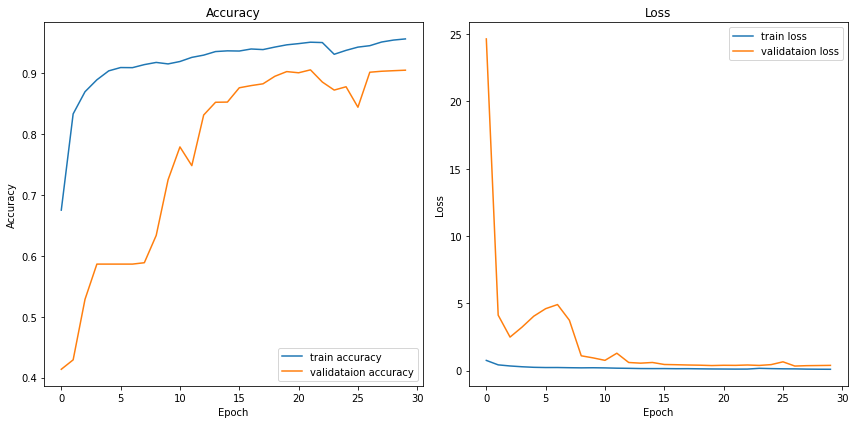

In [ ]:
# Display learning curves
learning_curves(unet_resnet50_model.history)